In [1]:
%pip install yfinance

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 0.0/949.2 kB ? eta -:--:--
     ------------------------------- ------ 786.4/949.2 kB 8.3 MB/s eta 0:00:01
     ---------------------------------------- 949.2/949.2 kB 4.9 MB/s  0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached soupsieve-2.8-py3-none-any.whl.metadata (4.6 kB)
   ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
   ---------------------------------------- 1.6/1.6 MB 21.5 MB/s  0:00:00
Using cached soupsieve-2.8-py3-none-any.whl (36 kB)
  Created wheel for multitasking: filename=multitasking-0.0.12-py3-none-any.w

  DEPRECATION: Building 'multitasking' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'multitasking'. Discussion can be found at https://github.com/pypa/pip/issues/6334


In [40]:
import yfinance as yf
import pandas as pd

# 1. yfinance로 데이터를 불러옵니다.
ticker = yf.Ticker('TSLA')
yfinance_df = ticker.history(period='1y')

df_formatted = yfinance_df.reset_index()
df_formatted = df_formatted[['Date', 'Open', 'High', 'Low', 'Volume', 'Close']]


print("--- 2. 이전 CSV와 동일한 형식으로 맞춘 데이터프레임 ---")
print(df_formatted.head())

--- 2. 이전 CSV와 동일한 형식으로 맞춘 데이터프레임 ---
                       Date        Open        High         Low    Volume  \
0 2024-10-29 00:00:00-04:00  264.510010  264.980011  255.509995  80521800   
1 2024-10-30 00:00:00-04:00  258.040009  263.350006  255.820007  53993600   
2 2024-10-31 00:00:00-04:00  257.989990  259.750000  249.250000  66575300   
3 2024-11-01 00:00:00-04:00  252.039993  254.000000  246.630005  57544800   
4 2024-11-04 00:00:00-05:00  244.559998  248.899994  238.880005  68802400   

        Close  
0  259.519989  
1  257.549988  
2  249.850006  
3  248.979996  
4  242.839996  


In [ ]:
# 독립변수, 종속변수 분리
# window size : 30 (한달치 데이터를 하나의 dataset)
# 배치는 3배치
# 알고리즘은 RNN

In [61]:

# ---------------------------------
# 1. 필요한 라이브러리 모두 import
# ---------------------------------
import yfinance as yf
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from torch.optim.adam import Adam

# ---------------------------------
# 2. StockDataSet 클래스 정의
# ---------------------------------
class StockDataSet(Dataset):
    def __init__(self, df):
        self.df = df
        feature_cols = ['Open', 'High', 'Low']
        label_col = 'Close'
        
        data_values = self.df[feature_cols].values
        label_values = self.df[[label_col]].values
        
        self.data = StandardScaler().fit_transform(data_values)
        self.label = StandardScaler().fit_transform(label_values)
        self.data = torch.FloatTensor(self.data)
        self.label = torch.FloatTensor(self.label)

    def __len__(self):
        return len(self.data) - 30
        
    def __getitem__(self, index):
        data = self.data[index:index+30]
        label = self.label[index + 30]
        return data, label

# ---------------------------------
# 3. StockRNN 클래스 정의
# ---------------------------------
class StockRNN(nn.Module):
    def __init__(self):
        super(StockRNN, self).__init__()
        self.rnn = nn.RNN(input_size=3, hidden_size=8, num_layers=5, batch_first=True)
        self.fc1 = nn.Linear(30*8, 64)
        self.fc2 = nn.Linear(64, 1)
        self.relu = nn.ReLU()
    
    def forward(self, x, ho):
        x, hn = self.rnn(x, ho)
        x = torch.reshape(x, (x.shape[0], -1))
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        out = torch.flatten(x)
        return out

# ---------------------------------
# 4. 데이터 준비 및 학습 설정
# ---------------------------------
# 데이터 불러오기 및 형식 맞추기
ticker = yf.Ticker('TSLA')
yfinance_df = ticker.history(period='1y')
df_formatted = yfinance_df.reset_index()
df_formatted = df_formatted[['Date', 'Open', 'High', 'Low', 'Volume', 'Close']]

# 학습 설정
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = StockRNN().to(device)

# 데이터셋 생성 시 df_formatted 전달
dataset = StockDataSet(df=df_formatted)

loader = DataLoader(dataset, batch_size=16)
optim = Adam(model.parameters(), lr=1e-3)

print("모든 설정이 성공적으로 완료되었습니다!")
print(f"사용 중인 장치: {device}")
print(f"데이터셋 샘플 개수: {len(dataset)}")

모든 설정이 성공적으로 완료되었습니다!
사용 중인 장치: cpu
데이터셋 샘플 개수: 220


In [62]:

from tqdm import tqdm
# criterian = nn.MSELoss()
for epoch in range(50):
    loop = tqdm(loader)
    for data, label in loop:
        optim.zero_grad()
        # 초기 은닉상태의 배치크기는 DataLoader가 주는 배치 크기
        batch_size = data.size(0)

        ho = torch.zeros(5,batch_size,8).to(device)
        # 모델의 예측값
        pred = model(data.to(device), ho)
        # 손실값
        loss = nn.MSELoss()(pred, label.to(device))
        loss.backward()
        optim.step()

        loop.set_description(f'epoch:{epoch+1} loss:{loss.item()}')
torch.save(model.state_dict(), './rnn.pth')

  0%|          | 0/14 [00:00<?, ?it/s]c:\Users\SAMSUNG\anaconda3\envs\deep\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
epoch:1 loss:2.584669589996338:  79%|███████▊  | 11/14 [00:00<00:00, 36.12it/s]  c:\Users\SAMSUNG\anaconda3\envs\deep\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([12, 1])) that is different to the input size (torch.Size([12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
epoch:50 loss:0.19807179272174835: 100%|██████████| 14/14 [00:00<00:00, 43.97it/s] 


In [63]:

# 모델 성능평가하기
import matplotlib.pyplot as plt

loader = DataLoader(dataset,batch_size=1)
preds = []
total_loss = 0
with torch.no_grad():
    model.load_state_dict(torch.load('rnn.pth', map_location=device,weights_only=False))
    for data, label in loader:
        # 초기 은닉상태의 배치크기는 DataLoader가 주는 배치 크기
        batch_size = data.size(0)

        ho = torch.zeros(5,batch_size,8).to(device)
        # 모델의 예측값
        pred = model(data.to(device), ho)
        preds.append(pred.item())
        # 손실값
        loss = nn.MSELoss()(pred, label.to(device))
        total_loss += (loss.item() / len(loader))

print(f'total_loss : {total_loss:.4f}')


c:\Users\SAMSUNG\anaconda3\envs\deep\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


total_loss : 0.1199


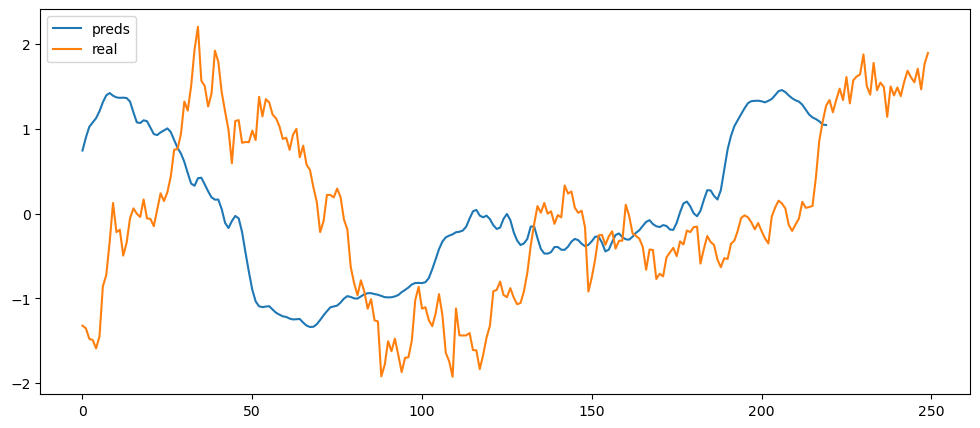

In [64]:
plt.figure(figsize=(12,5))
plt.plot(preds, label = 'preds')
plt.plot(dataset.label, label = 'real')
plt.legend()
plt.show() 